In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [7]:
def normalize(im, to255=True):
    im = im.copy()
    im -= im.min()
    if im.max() > 0:
        im /= im.max()
    if to255:
        im *= 255.0
        return im.astype(np.uint8)
    return im

def realce_espacial_pipeline(img: np.ndarray):
    # Laplaciano
    laplacian_kernel = np.array([[ 0, -1,  0],
                                 [-1,  4, -1],
                                 [ 0, -1,  0]], dtype=np.float32)
    b = cv2.filter2D(img, ddepth=-1, kernel=laplacian_kernel)
    b_disp = normalize(b)

    # Imagem aguçada
    c = img + b
    c_disp = normalize(c)

    # Gradientes de Sobel
    gx = cv2.filter2D(img, ddepth=-1, kernel=np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32))
    gy = cv2.filter2D(img, ddepth=-1, kernel=np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32))
    M = np.sqrt(gx**2 + gy**2)
    d_disp = normalize(M)

    # Suavização
    e = cv2.filter2D(M, ddepth=-1, kernel=np.ones((5, 5), dtype=np.float32) / 25.0)
    e_disp = normalize(e)

    # Máscara
    f = b * e
    f_disp = normalize(f)

    # Imagem realçada
    g = img + f
    g_disp = normalize(g)

    # Transformação de potência
    g_norm = normalize(g, to255=False)
    h_norm = np.power(g_norm, 0.5)
    h_disp = (h_norm * 255.0).astype(np.uint8)

    return [
        img.astype(np.uint8), b_disp, c_disp,
        d_disp, e_disp, f_disp, g_disp, h_disp
    ]


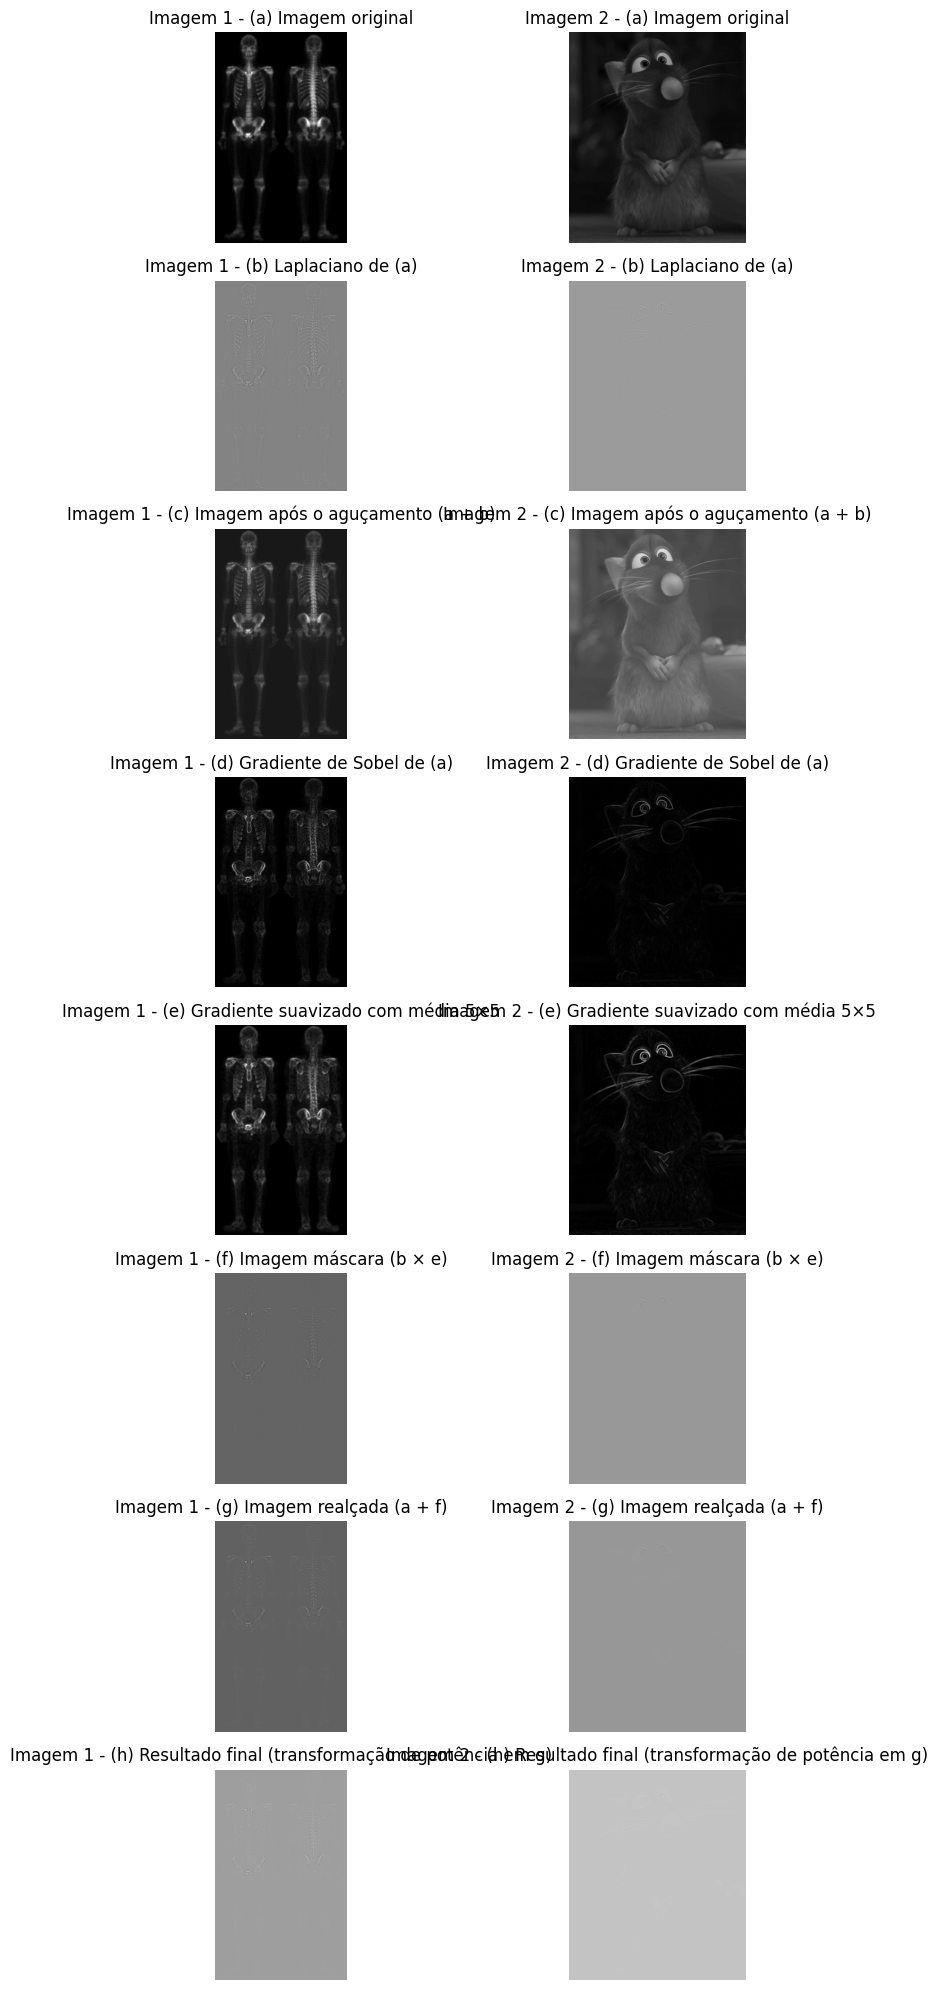

In [10]:
import matplotlib.pyplot as plt

# Carrega duas imagens
img1 = cv2.imread("Fig0343(a)(skeleton_orig).tif", cv2.IMREAD_GRAYSCALE).astype(np.float32)
img2 = cv2.imread("remi.webp", cv2.IMREAD_GRAYSCALE).astype(np.float32)

# Processa ambas
res1 = realce_espacial_pipeline(img1)
res2 = realce_espacial_pipeline(img2)

# Nomes dos passos
titles = [
    "(a) Imagem original", "(b) Laplaciano de (a)",
    "(c) Imagem após o aguçamento (a + b)", "(d) Gradiente de Sobel de (a)",
    "(e) Gradiente suavizado com média 5×5", "(f) Imagem máscara (b × e)",
    "(g) Imagem realçada (a + f)", "(h) Resultado final (transformação de potência em g)"
]

# Plot lado a lado
fig, axs = plt.subplots(8, 2, figsize=(10, 20))

for i in range(8):
    axs[i, 0].imshow(res1[i], cmap='gray', vmin=0, vmax=255)
    axs[i, 0].set_title(f"Imagem 1 - {titles[i]}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(res2[i], cmap='gray', vmin=0, vmax=255)
    axs[i, 1].set_title(f"Imagem 2 - {titles[i]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


PERGUNTA: O mesmo procedimento funcionou para sua imagem? Explique. Foram necessárias algumas modificações para que funcionasse? Explique as modificações realizadas e o porque de ter optado por elas.

Resposta: 

Sim, o procedimento apresentou um funcionamento bastante semelhante tanto na imagem original do exemplo (Fig0343(a)(skeleton_orig).tif) quanto na imagem que escolhi (remi.webp). Visualmente, ambas passaram por transformações parecidas ao longo do pipeline de realce espacial, resultando em imagens finais com bordas mais destacadas, melhor definição das estruturas e um contraste mais evidente.

Foi possível observar resultados parecidos especialmente nas etapas de Gradiente de Sobel e suavização com média 5×5, onde as duas imagens ganharam bastante nitidez. Por outro lado, nas etapas de realce e geração da máscara, ambas acabaram perdendo contraste original, o que é esperado dependendo das características da imagem de entrada.

No geral, o método funcionou bem nas duas imagens sem necessidade de alterações no código, o que mostra que ele é versátil. Porém, em imagens com muito brilho ou ruído, pode ser necessário ajustar parâmetros como o valor de gamma ou aplicar algum tipo de suavização antes de iniciar o processamento.